This notebooks works like the monte_carlo notebook, except with only one price and one market situation.
The time between adjustmensts of prices gets split into B parts and for each purchase the time slot o fit is tracked. At the end, it creates a graph. The time horizon is 1.

In [1]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd

Set our start values.

In [2]:
num_firm = 5                        # the number of firms which we simulate
time_horizon = 1                    # set the time horizon which we watch to 1 
num_market_events = 2               # the max price adjustments each firm will make
mean_betw_customer_arrival = 2      # chose mean for how often customers appear
num_customer_events = 4             # max 4 customers arrive in time horizon
watched_firm = 0                   
num_sims = 10000                    # set the number of simulations to run 
reaction_time_firm = time_horizon   # watched firm doesn't update price
intensity_price = 7                 # the price for the watched firm
bb = 20                             # number of times to split time horizon
setups = ["S1","S2","S3"]           # set the names of different setups
random.seed(32859786)               # set a random seed to always get comparable results
#betw = between

In [3]:
# calculate price depending on prices from competing firms
def price_if_smaller_else(price, price_threshold, min_price, prices_firm, c):
    return(
        price 
        if min([prices_firm[c] for firm in range(num_firm) if firm!=c]) < price_threshold 
        else round(
            min([
                    max(min_price, prices_firm[firm] - 0.5) for firm in range(num_firm) if firm != c])
            ,2))

# define the three different setups from the paper
s1 = {
        '0' : lambda prices_firm, c: round(random.uniform(0,15),2),
        '1' : lambda prices_firm, c: round(random.uniform(5,15),2),
        '2' : lambda prices_firm, c: round(random.uniform(5,15),2),
        '3' : lambda prices_firm, c: round(random.uniform(5,15),2),
        '4' : lambda prices_firm, c: round(random.uniform(5,15),2)
    }

s2 = {
        '0' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '1' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '2' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '3' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '4' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c)
    }

s3 = {
        '0' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '1' : lambda prices_firm, c: price_if_smaller_else(9,4,3.9,prices_firm,c),
        '2' : lambda prices_firm, c: price_if_smaller_else(12,6,5.9,prices_firm,c),
        '3' : lambda prices_firm, c: 11,
        '4' : lambda prices_firm, c: 13
    }

In [4]:
def calc_prices(prices_firm_adjust, adjusting_firm, setup):
    prices_firm_adjust = np.array(prices_firm_adjust)
    #weird indexing because there are actually no price adjustments at time 0 nor on the price horizon
    for i in range(1,len(prices_firm_adjust)-1):         
        prices_firm_adjust[i:,adjusting_firm[i]] = setup[str(adjusting_firm[i])](prices_firm_adjust[i-1],adjusting_firm[i])
    return prices_firm_adjust

Calculate all the necessary information for when firms adjusts their prices and how often they adjust their prices.  

In [5]:
time_betw_market_events_firm = np.random.uniform(0.8,1.2, (num_sims, num_firm, num_market_events))

time_adjusts_firm = time_betw_market_events_firm
time_adjusts_firm[:,:,0] = np.random.uniform(0, 1, (num_sims, num_firm))

# calculate the time when each company adjusts their prices
for sim_num in range(num_sims):
    for firm in range(num_firm):
        for i in range(1, num_market_events):
            time_adjusts_firm[sim_num, firm, i] = (time_adjusts_firm[sim_num, firm, i-1] + 
                                                   time_betw_market_events_firm[sim_num, firm, i])   

price_adjusts_before_horizon = np.array(
    [
        set([
            time_adjusts_firm[sim_num].flatten()[i] 
            for i in range(len(time_adjusts_firm[sim_num].flatten())) 
            if time_adjusts_firm[sim_num].flatten()[i] < time_horizon]) 
        for sim_num in range(num_sims)])

price_adjusts_before_horizon = np.array(
    [
        [0] + sorted(price_adjusts_before_horizon[sim_num]) + [time_horizon] 
        for sim_num in range(num_sims)])

num_price_adjusts_before_horizon = np.array(
    [
        len(price_adjusts_before_horizon[sim_num])
        for sim_num in range(num_sims)])

adjusting_firm = np.array(
    [[
            min(np.where(time_adjusts_firm[sim_num]==price_adjusts_before_horizon[sim_num][i] )[0]) 
            if price_adjusts_before_horizon[sim_num][i]!= time_horizon and i!=0 
            else -1 
            for i in range(num_price_adjusts_before_horizon[sim_num])] 
        for sim_num in range(num_sims)])

Calculate when customers will arrive and how they will score the quality and rating of all firms.

In [6]:
time_betw_customer_events = mean_betw_customer_arrival* np.random.exponential(size=(num_sims, num_customer_events)) 

time_customer_events = time_betw_customer_events

#calculate the arrival of customers after the first one
for sim_num in range(num_sims):
    for customer in range(1, num_customer_events):
        time_customer_events[sim_num, customer] = (time_customer_events[sim_num, customer-1] + 
                                                   time_betw_customer_events[sim_num, customer])

rand_customer_score_qual = np.random.uniform(0,1, (num_sims, num_customer_events))

rand_customer_score_rating = rand_customer_score_qual = np.random.uniform(0,0.5, (num_sims, num_customer_events))

customer_score_qual_rating = np.zeros(shape=(num_sims, num_customer_events, num_firm))

#calculate the score from each customer for each firm based on quality and rating of the offers
for sim_num in range(num_sims):
    for customer in range(num_customer_events):
        customer_score_qual_rating[sim_num, customer, :] = (rand_customer_score_qual[sim_num, customer]*2 + 
                                                            rand_customer_score_rating[sim_num, customer]*(100-98))

Calculate the prices adjustments for each firm in the time horizon.

In [7]:
prices_firm = np.array(
    [
        intensity_price+20.5+2*(k-2) 
        if k!=watched_firm 
        else intensity_price  
        for k in range(num_firm)])

prices_firm_adjust = np.array(
    [[[
                prices_firm[k]  
                for k in range(num_firm)]
            for _ in range(num_price_adjusts_before_horizon[s])] 
        for s in range(num_sims)])

prices_firm_adjust = np.array(
    [[
            np.array(calc_prices(prices_firm_adjust[s], adjusting_firm[s], globals()["s{}".format(setup+1)])) 
            for s in range(num_sims)]
        for setup in range(len(setups))])

As we don't want to know what happens after or on the time horizon, we will always substract 1 when using the value num_price_adjusts_before_horizon in the following code.

In [8]:
# get all the customers that appear between market events, so we don't always have to iterate through each customer
gen = np.array(
    [[
            list([
                x 
                for x in range(num_customer_events) 
                if price_adjusts_before_horizon[s][i]< time_customer_events[s][x]< price_adjusts_before_horizon[s][i+1]]) 
            for i in range(num_price_adjusts_before_horizon[s] - 1)] 
        for s in range(num_sims)] )

Simulate the customer by completing the score using the current prices of each firm and then calculating a decision for each customer.

In [9]:
rand_customer_score = np.array(
    [[[[[
                        (prices_firm_adjust[setup,s][i,k] + customer_score_qual_rating[s,c,k]) 
                        for k in range(num_firm)]
                    for c in gen[s][i]]
                for i in range(num_price_adjusts_before_horizon[s] - 1)] 
            for s in range(num_sims)]
        for setup in range(len(setups))])

rand_customer_decision = np.array(
    [[[[
                    np.argmin(rand_customer_score[setup,s][i][c]) 
                    if min(rand_customer_score[setup,s][i][c])< random.uniform(5,15) 
                    else -1 
                    for c in range(len(gen[s][i]))]
                for i in range(num_price_adjusts_before_horizon[s] - 1)] 
            for s in range(num_sims)]
        for setup in range(len(setups))])

Split our time horizon in bb parts and calculate how often our watched company sells their product in each time slot.

In [10]:
b = np.array(
    [[[
                int(round((time_customer_events[s][c]+1/bb/2)*bb))
                for c in range(len(gen[s][i]))]
            for i in range(num_price_adjusts_before_horizon[s] - 1)] 
        for s in range(num_sims)])

At = np.array(
    [[[
                sum([
                     sum([
                          sum([
                               1 
                               if b[s][i][c]==t and rand_customer_decision[setup,s][i][c]==k  
                               else 0 
                               for c in range(len(gen[s][i]))])
                          for i in range(num_price_adjusts_before_horizon[s] - 1)])
                     for s in range(num_sims)])
                for k in range(num_firm)]
            for t in range(reaction_time_firm*bb+1)]
        for setup in range(len(setups))])

Create our plot.

In [11]:
x = [
        t/bb 
        for t in range(1,reaction_time_firm*bb+1)]

for i in range(len(setups)):
    plt.plot(x, [At[i,t][watched_firm]/num_sims*bb for t in range(1,len(x)+1)], label=setups[i])
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('E(λ$_t$)')

Text(0,0.5,'E(λ$_t$)')

Simulated expected sales intensities of firm 1 over one period of time time for different firmetitive setups (i)-(iii), starting in market situation s0 , cf.

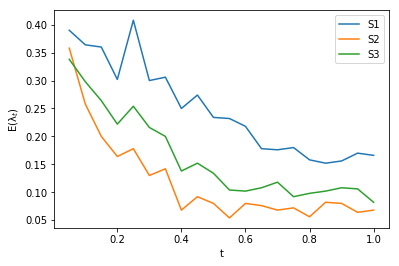

In [12]:
plt.show()